In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *
from ArNet.generators import *
from ArNet.critics import *
from ArNet.dataset import *
from ArNet.loss import *
from ArNet.save import *
from ArNet.fid_loss import *
from ArNet.ssim import *
from ArNet.metrics import *
from pathlib import Path
import torch.nn.functional as F

import torchvision
import geffnet # efficient/ mobile net

In [7]:
def get_DIV2k_data_QF(pLow, bs:int, sz:int):
    """Given the path of low resolution images
       returns a databunch
    """
    src = ImageImageList.from_folder(pLow).split_by_idxs(train_idx=list(range(0,800)), valid_idx=list(range(800,900)))
    
    data = (src.label_from_func(lambda x: path_fullRes/(x.name.replace(".jpg", ".png"))).transform(
            get_transforms(
                max_rotate=30,
                max_lighting=.4,
                max_warp=.4
            ),
            size=sz,
            tfm_y=True,
        ).databunch(bs=bs, num_workers=8, no_check=True).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [8]:
def do_fit(learn, epochs,save_name, lrs=slice(1e-3), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=7)

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

proj_id = 'unet_superRes_mobilenetV3_SSIM'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

nf_factor = 2
pct_start = 1e-8

In [10]:
print(path_fullRes)

dataset/DIV2K_train_HR


# Test metric values

In [11]:
pathLenna = path / "Lenna_imgs"

In [12]:
pathLenna.ls()

[PosixPath('dataset/Lenna_imgs/Lenna_jpeg.jpg'),
 PosixPath('dataset/Lenna_imgs/Lenna_invese.png'),
 PosixPath('dataset/Lenna_imgs/Lenna_warp.png'),
 PosixPath('dataset/Lenna_imgs/Lenna_Blur.png'),
 PosixPath('dataset/Lenna_imgs/Lenna_Noise.png'),
 PosixPath('dataset/Lenna_imgs/Lenna_original.png')]

In [13]:
lenna_original = open_image("dataset/Lenna_imgs/Lenna_original.png")
lenna_warp = open_image("dataset/Lenna_imgs/Lenna_warp.png")
lenna_blur = open_image("dataset/Lenna_imgs/Lenna_Blur.png")
lenna_jpeg = open_image("dataset/Lenna_imgs/Lenna_jpeg.jpg")
lenna_noise = open_image("dataset/Lenna_imgs/Lenna_Noise.png")

print(lenna_original.data.size())

torch.Size([3, 512, 512])


In [14]:
noise_tensor = torch.empty(3, 512,512).uniform_(0, 1)

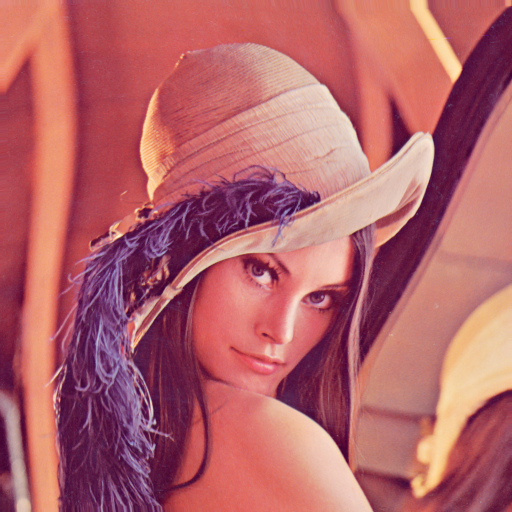

In [15]:
lenna_warp

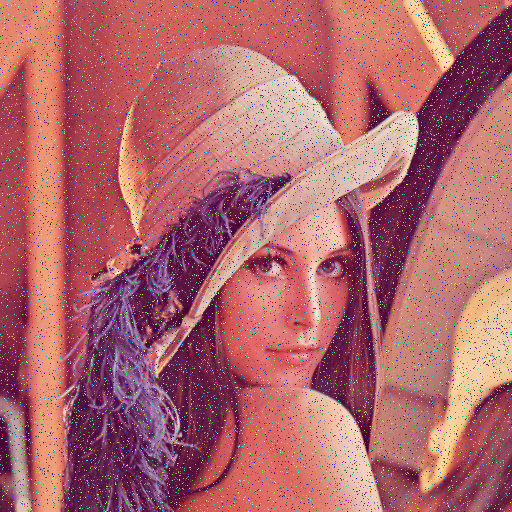

In [16]:
lenna_noise

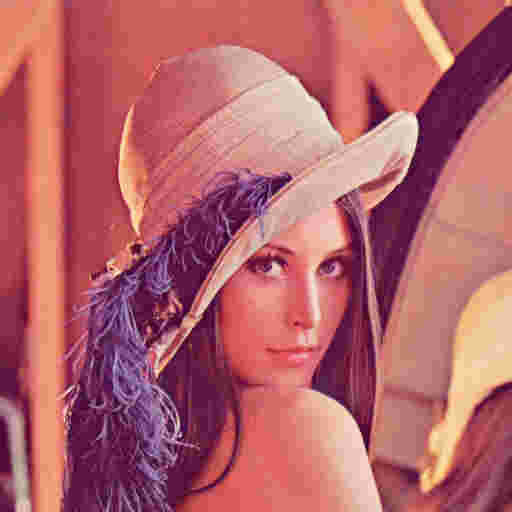

In [17]:
lenna_jpeg

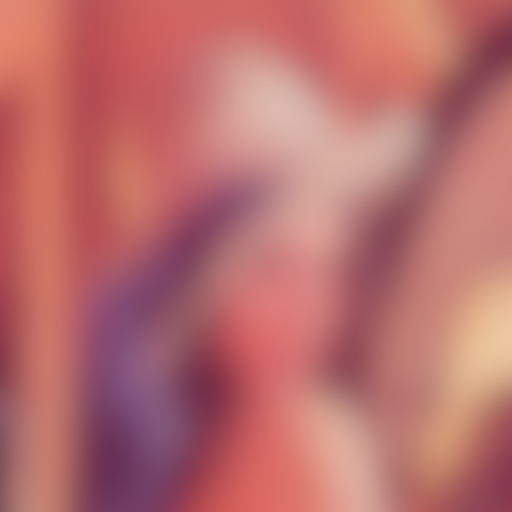

In [18]:
lenna_blur

In [19]:
lpips_metric = lpips.PerceptualLoss(model='net-lin', net='alex', use_gpu=True, gpu_ids=[0])

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


### originale

In [20]:
1 - ssim(lenna_original.data[None], lenna_original.data[None])

tensor(1.)

In [21]:
lpips_metric(lenna_original.data, lenna_original.data)

tensor([[[[0.]]]], device='cuda:0', grad_fn=<AddBackward0>)

### warp

In [22]:
1 - ssim(lenna_original.data[None], lenna_warp.data[None])

tensor(0.4273)

In [23]:
(1 - lpips_metric(lenna_original.data, lenna_warp.data))/1.27

tensor([[[[0.5239]]]], device='cuda:0', grad_fn=<DivBackward0>)

### blur

In [24]:
1 - ssim(lenna_original.data[None], lenna_blur.data[None])

tensor(0.5479)

In [25]:
(1 - lpips_metric(lenna_original.data, lenna_blur.data))/1.27

tensor([[[[0.2965]]]], device='cuda:0', grad_fn=<DivBackward0>)

### jpeg

In [26]:
1 - ssim(lenna_original.data[None], lenna_jpeg.data[None])

tensor(0.7322)

In [27]:
lpips_metric(lenna_original.data, lenna_jpeg.data)

tensor([[[[0.1576]]]], device='cuda:0', grad_fn=<AddBackward0>)

### Noise

In [28]:
1 - ssim(lenna_original.data[None], lenna_noise.data[None])

tensor(0.3105)

In [29]:
(1 - lpips_metric(lenna_original.data, lenna_noise.data))/1.27

tensor([[[[0.3330]]]], device='cuda:0', grad_fn=<DivBackward0>)

In [30]:
from brisque import BRISQUE

brisque_metric = BRISQUE()

In [31]:
# brisque takes tensors with (w x h x channel) shape
brisque_metric.get_score(lenna_noise.data.permute(1, 2, 0).numpy())

97.44369836360227

In [32]:
from skvideo.measure.niqe import niqe

In [33]:
niqe(lenna_noise.data.numpy())

array([24.395811, 24.113686, 23.30163 ], dtype=float32)

# LPIPS batch

In [34]:
bs=10
sz=256
lr = 1e-2
wd = 1e-3
epochs = 1

data_gen = get_DIV2k_data_QF(path_lowRes_128, bs=bs, sz=sz)

x, y = data_gen.one_batch()

In [35]:
mod = lpips.PerceptualLoss(model='net-lin', net='alex', use_gpu=True, gpu_ids=[0])
d = mod.forward(x,y);

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [36]:
d.size()

torch.Size([10, 1, 1, 1])

In [37]:
d.mean()

tensor(0.3810, device='cuda:0', grad_fn=<MeanBackward0>)

# Brisque

In [38]:
from brisque import BRISQUE

In [39]:
brisque = BRISQUE()

In [40]:
x[0].shape

torch.Size([3, 256, 256])

In [41]:
x[0].permute(1, 2, 0).numpy().shape

(256, 256, 3)

In [42]:
brisque.get_score(x[0].permute(1, 2, 0).numpy())

119.10616952020843

# NIQE

In [43]:
from skvideo.measure.niqe import *
from torchvision import transforms

In [44]:
x[0][0].shape

torch.Size([256, 256])

In [45]:
values = []
for img in x:
    score = niqe(img[0].numpy())
    values.append(score)
values

[array([27.152546], dtype=float32),
 array([25.214308], dtype=float32),
 array([25.914682], dtype=float32),
 array([25.328392], dtype=float32),
 array([25.09236], dtype=float32),
 array([25.201395], dtype=float32),
 array([25.408411], dtype=float32),
 array([26.829681], dtype=float32),
 array([26.346024], dtype=float32),
 array([27.180517], dtype=float32)]

In [46]:
niqe(x[0][0].numpy())

array([27.152546], dtype=float32)

# Test fit with metrics

In [47]:
bs=40
sz=32
lr = 1e-2
wd = 1e-3
epochs = 1

model = geffnet.mobilenetv3_small_minimal_100

loss_func = F.mse_loss

loss_func = F.mse_loss

In [48]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [8]:
data_gen = get_DIV2k_data_QF(path_lowRes_128, path_fullRes, bs=10, sz=256)

In [51]:
learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=nf_factor)

In [52]:
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(LPIPS_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done
Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [53]:
learn_gen.metrics

[LPIPS_Metric_gen,
 LPIPS_Metric_input,
 BRISQUE_Metric_gen,
 BRISQUE_Metric_input,
 BRISQUE_Metric_target,
 NIQE_Metric_gen,
 NIQE_Metric_input,
 NIQE_Metric_target]

In [54]:
learn_gen.fit_one_cycle(1, lr, pct_start=.9)

epoch,train_loss,valid_loss,lpips_gen,lpips_in,brisque_gen,brisque_in,brisque_tar,niqe_gen,niqe_in,niqe_tar,time
0,0.353601,0.149853,0.462862,0.408446,80.857200,96.264983,79.548818,20.032480,22.641680,19.608082,02:43


# Test architectures

In [3]:
data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=10, sz=256)

In [23]:
mobile = geffnet.mobilenetv3_small_minimal_100

In [5]:
dir(geffnet)

['F',
 'GenEfficientNet',
 'HardSigmoid',
 'HardSwish',
 'Mish',
 'MishAuto',
 'MishJit',
 'Sigmoid',
 'Swish',
 'SwishAuto',
 'SwishJit',
 'Tanh',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'activations',
 'activations_autofn',
 'activations_jit',
 'add_override_act_fn',
 'add_override_act_layer',
 'clear_override_act_fn',
 'clear_override_act_layer',
 'config',
 'conv2d_layers',
 'create_model',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_builder',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'fbnetc_100',
 'gen_efficientnet',


In [27]:
learn_gen = gen_learner_wide(data=data_gen, arch=mobile, gen_loss=SSIM, nf_factor=1)

learn_gen.summary()

DynamicUnetWide
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 128, 128]       432        False     
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
ReLU                 [16, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [16, 64, 64]         144        False     
______________________________________________________________________
BatchNorm2d          [16, 64, 64]         32         True      
______________________________________________________________________
ReLU                 [16, 64, 64]         0          False     
______________________________________________________________________
Identity             [16, 64, 64]         0          False     
______________________________________________

In [57]:
res = models.resnet34

print(res.__module__)
help(res)

torchvision.models.resnet
Help on function resnet34 in module torchvision.models.resnet:

resnet34(pretrained=False, progress=True, **kwargs)
    ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr



In [62]:
learn_gen = gen_learner_wide(data=data_gen, arch=res, gen_loss=msssim, nf_factor=2)

learn_gen.summary()

DynamicUnetWide
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________

In [66]:
shuffle = models.shufflenet_v2_x2_0 # Not supported 
print(type(shuffle))
help(shuffle)

<class 'function'>
Help on function shufflenet_v2_x2_0 in module torchvision.models.shufflenetv2:

shufflenet_v2_x2_0(pretrained=False, progress=True, **kwargs)
    Constructs a ShuffleNetV2 with 2.0x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`_.
    
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr



In [67]:
efficient = geffnet.efficientnet_b1
print(type(efficient))
help(efficient)

<class 'function'>
Help on function efficientnet_b1 in module geffnet.gen_efficientnet:

efficientnet_b1(pretrained=False, **kwargs)
    EfficientNet-B1



In [68]:
learn_gen = gen_learner_wide(data=data_gen, arch=efficient, gen_loss=msssim, nf_factor=2)

learn_gen.summary()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /data/students_home/fmameli/.cache/torch/checkpoints/efficientnet_b1-533bc792.pth


DynamicUnetWide
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 128, 128]       864        False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
SwishJit             [32, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [32, 128, 128]       288        False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
SwishJit             [32, 128, 128]       0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [32, 1, 1]           0          False     
______________________________________________

# Dataset setup

Create QF20 jpeg imgs

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_1024 = path/'DIV2K_train_LR_1024_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

In [3]:
path_fullRes_mixed = path/'DIV2K_Flickr_Mixed_HR'


path_lowRes_512_mixed = path/'DIV2K_Flickr_Mixed_LR_512_QF20'
path_lowRes_1024_mixed = path/'DIV2K_Flickr_Mixed_LR_1024_QF20'

In [ ]:
datasets = [(path_lowRes_256, 256, 20), (path_lowRes_512, 512, 20)]

In [ ]:
create_dataset(path_fullRes, datasets, downsize=True)

In [ ]:
datasets = [(path_lowRes_1024, 1024, 20)]

In [ ]:
create_dataset(path_fullRes, datasets, downsize=True)

In [ ]:
datasets = [(path_lowRes_Full, 0, 20)]

In [ ]:
create_dataset(path_fullRes, datasets, downsize=False)

# Mixed with ffhd

In [4]:
datasets = [(path_lowRes_1024_mixed, 1024, 20), (path_lowRes_512_mixed, 512, 20)]

In [5]:
create_dataset(path_fullRes_mixed, datasets, downsize=True)

Creating dataset/DIV2K_Flickr_Mixed_LR_1024_QF20
Size: 1024 with 20 quality factor


Creating dataset/DIV2K_Flickr_Mixed_LR_512_QF20
Size: 512 with 20 quality factor


# Flickr2k

In [10]:
path_fullRes_flickr = path/'Flickr2K'/'Flickr2K_HR'

path_lowRes_flickr_512 = path/'Flickr2K'/'Flickr2K_LR_512_QF20'
path_lowRes_flickr_1024 = path/'Flickr2K'/'Flickr2K_LR_1024_QF20'

datasets = [(path_lowRes_flickr_512, 512, 20), (path_lowRes_flickr_1024, 1024, 20)]

In [11]:
create_dataset(path_fullRes_flickr, datasets, downsize=True)

Creating dataset/Flickr2K/Flickr2K_LR_512_QF20
Size: 512 with 20 quality factor


Creating dataset/Flickr2K/Flickr2K_LR_1024_QF20
Size: 1024 with 20 quality factor


# Test FID

In [70]:
from superRes.fid_loss import *

In [72]:
x, y = data_gen.one_batch()

In [73]:
x.shape

torch.Size([10, 3, 256, 256])

In [74]:
fid(x, y)

tensor(0.2551, device='cuda:0', grad_fn=<AddBackward0>)

# View img patches

In [10]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_256 = path/'DIV2K_train_LR_256_QF20'
path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
path_lowRes_1k = path/'DIV2K_train_LR_1024_QF20'
path_lowRes_Full = path/'DIV2K_train_LR_Full_QF20'

In [4]:
def plot_patched_image(p):
    _, axs = plt.subplots(p.shape[0], p.shape[1], figsize=(10, 10))
    for i in range(p.shape[0]):
        for j in range(p.shape[1]):
            Image(p[i][j]).show(ax=axs[i, j])

def get_patches(tensor):
    pw, ph = 64, 64
    nc, w, h = tensor.shape
    padW = pw - w%pw
    padH = ph - h%ph
    paded = F.pad(tensor, (padH, 0, padW, 0), value=1)
    patches = paded.unfold(0, nc, nc).unfold(1, ph, ph).unfold(2, pw, pw)
    return patches

In [11]:
high_res = ImageList.from_folder(path_fullRes, presort=True)
# low_res  = ImageList.from_folder(path_lowRes_Full, presort=True)
low_res  = ImageList.from_folder(path_lowRes_1k, presort=True)

print(low_res[10].shape)
print(high_res[10].shape)

torch.Size([3, 1024, 1540])
torch.Size([3, 1356, 2040])


In [12]:
index = 6
resizedImg = low_res[index].resize(high_res[index].shape).clone()

In [13]:
resizedImg.shape == high_res[index].shape

True

torch.Size([22, 32, 3, 64, 64])


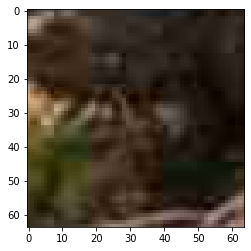

In [14]:
patch_img = get_patches(resizedImg.data)[0]
print(patch_img.shape)
plt.imshow(patch_img[17][26].permute(1, 2, 0), interpolation='nearest')
# plot_patched_image(patch_img)

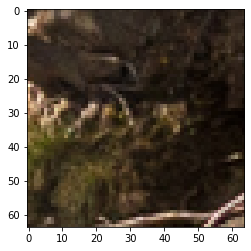

In [15]:
patch_img = get_patches(high_res[index].data)[0]
patch_img[4][2].shape
plt.imshow(patch_img[17][26].permute(1, 2, 0), interpolation='nearest')
# plot_patched_image(patch_img)